In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import pickle
import pandas as pd
import cudf
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import BisectingKMeans

In [2]:
EXP_NO = 'exp006'
TRAIN_PATH = '../data/processed/train.csv'
OUTPUT_DIR = Path(f'../model/item2vec/{EXP_NO}')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CATEGORY_TYPES = ["A", "B", "C", "D"]

In [3]:
df = cudf.read_csv(TRAIN_PATH, parse_dates=['time_stamp']).to_pandas()

all_product_ids = df['product_id'].unique()
df = df[df['event_type']>0]
df = df.sort_values(['user_id', 'time_stamp']).reset_index(drop=True)

In [4]:
for category in CATEGORY_TYPES:
    df_ = df[df['category'] == category]
    favorite_items = df_.groupby('user_id').agg({'product_id': list}).reset_index()
    
    with open(OUTPUT_DIR/f'items_{category}.txt', 'w') as f:
        for user_id, items in favorite_items.values:
            items = [items[i] for i in range(len(items)) if i==0 or items[i] != items[i-1]]
            f.write(' '.join(items) + '\n')
            
    sentences = word2vec.LineSentence(OUTPUT_DIR/f'items_{category}.txt')
    model = word2vec.Word2Vec(sentences, vector_size=128, epochs=20, window=10, min_count=1, ns_exponent=0.0, seed=0, workers=8)
    print(f'vectors.shape: {model.wv.vectors.shape}')
    with open(OUTPUT_DIR/f'item2vec_{category}.pickle', 'wb') as f:
        pickle.dump(model, f)

vectors.shape: (13768, 128)
vectors.shape: (16894, 128)
vectors.shape: (313609, 128)
vectors.shape: (348696, 128)


15    1420
2     1273
10    1251
8     1195
11    1128
16    1107
0      843
4      821
7      689
3      678
19     522
14     509
13     451
5      431
9      424
1      308
17     235
6      208
18     158
12     117
dtype: int64


/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


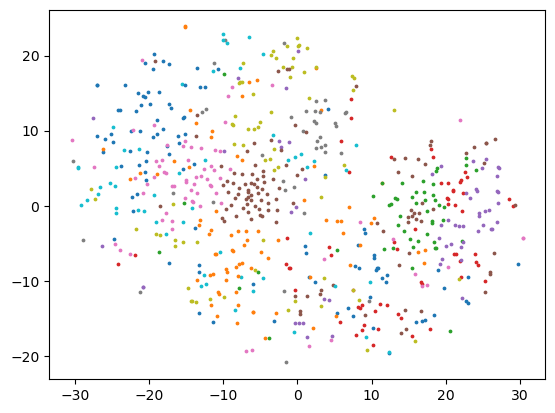

9     2389
18    1962
13    1513
1     1401
4     1320
17    1296
0     1289
5     1172
10    1172
14     928
19     483
12     449
16     426
11     300
15     274
7      191
2      176
8       76
3       49
6       28
dtype: int64


/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


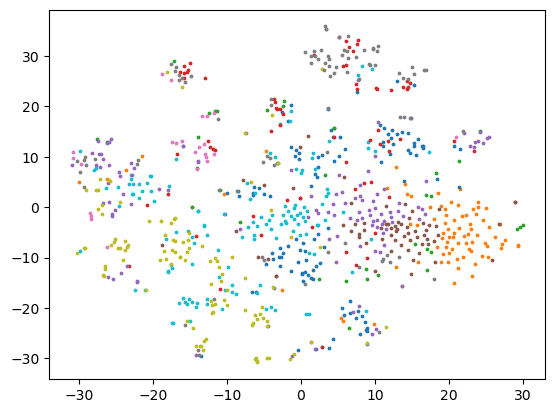

9     26220
1     25239
18    23616
17    23330
5     22774
2     20457
15    18919
12    17020
3     16818
11    16478
8     16249
0     15292
6     13562
16    12709
7     12011
4     11144
14     8778
19     8246
10     4701
13       46
dtype: int64


/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


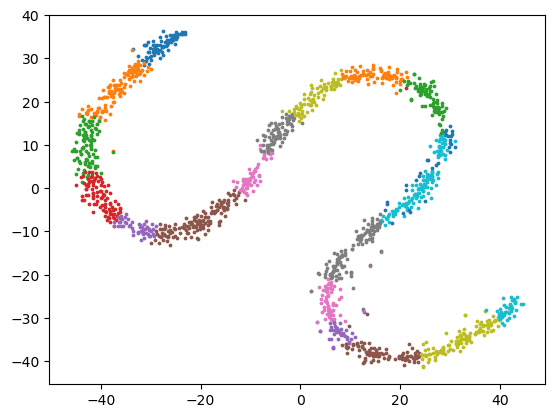

19    26909
6     24748
16    22727
17    21777
4     20220
8     18919
9     18833
1     17870
10    17087
5     16453
11    16411
15    16276
13    15710
12    15557
3     14673
2     14391
14    13788
7     12556
0     12455
18    11336
dtype: int64


/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


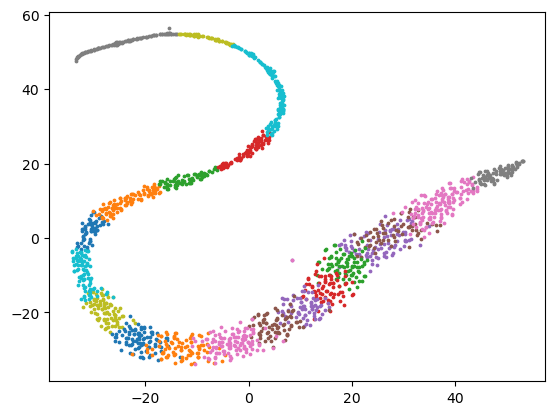

In [5]:
item_cluster = []
for i, category in enumerate(CATEGORY_TYPES):
    with open(OUTPUT_DIR/f'item2vec_{category}.pickle', 'rb') as f:
        model = pickle.load(f)
        
    vectors = model.wv.vectors
    item_names = model.wv.index_to_key
    categories = np.array(list(map(lambda s: s.split('_')[1], item_names)))
    
    k = 20
    vectors = vectors / np.linalg.norm(vectors).reshape(-1, 1)
    kmeans = BisectingKMeans(n_clusters=k, bisecting_strategy='largest_cluster', random_state=0)
    C = kmeans.fit_predict(vectors)
    item_cluster += list(zip(item_names, C))
    
    with open(OUTPUT_DIR/f'kmeans_{category}.pickle', 'wb') as f:
        pickle.dump(kmeans, f)
    
    print(pd.Series(C).value_counts())
    n = 20 if category in ['A', 'B'] else 200
    vectors = vectors[::n]
    item_names = item_names[::n]
    categories = categories[::n]
    C = C[::n]
    
    tsne = TSNE(perplexity=30)
    Z = tsne.fit_transform(vectors)
    
    for c in range(kmeans.n_clusters):
        idx = C==c
        plt.scatter(Z[idx, 0], Z[idx, 1], s=3)
    plt.show()

In [6]:
item_cluster = pd.DataFrame(item_cluster, columns=['product_id', 'cluster_id'])
rare_items = list(set(all_product_ids) - set(item_cluster['product_id']))
rare_items = pd.DataFrame({'product_id':rare_items, 'cluster_id':-1})
item_cluster = pd.concat([item_cluster, rare_items]).reset_index(drop=True)
item_cluster.to_csv(OUTPUT_DIR/'item_cluster.csv', index=False)

In [7]:
item_cluster.head()

,product_id,cluster_id
0,00013874_a,15
1,00005175_a,10
2,00001225_a,13
3,00001943_a,12
4,00001429_a,11
